### Import dependencies

In [1]:
# File management
import os
import glob
import requests
import json
import time
import random

# Audio processing
import librosa as li
from scipy import signal
import soundfile as sf

# Plotting
from matplotlib import pyplot as plt

# Machine Learning
import numpy as np
import tensorflow as tf

### Download argentinian birds dataset from Xeno-Canto

#### Query Xeno-Canto API and save response as JSON file

In [2]:
dataset_location = '..\\datasets\\xeno-canto_argentina\\'

# Query variables
country = 'argentina'
group = 'birds'
length = '2-60'
since = '2010-01-01'
q = 'A'

In [3]:
url = "https://xeno-canto.org/api/2/recordings?query="
params = f"cnt:{country}+grp:{group}+len:{length}+since:{since}+q:{q}"

response = requests.get(url + params)

print(f'• Query result: status-code {response.status_code}')

if response.status_code == 200:
  data = response.json()
  
  n_rec = data['numRecordings']
  pages = data['numPages']
  print(f'• Found {n_rec} recordings in {pages} pages.')

• Query result: status-code 200
• Found 2922 recordings in 6 pages.


In [4]:
# Write json files for all pages
for p in range(1, pages + 1):
  response = requests.get(url + params + f'&page={p}')
  data = response.json()
  
  filename = f"query_{str(p)}.json"
  with open(dataset_location + filename, "w") as file:
    json.dump(data, file, sort_keys=True, indent=4)
    print(f'• Saved page {p} as {filename}')

• Saved page 1 as query_1.json
• Saved page 2 as query_2.json
• Saved page 3 as query_3.json
• Saved page 4 as query_4.json
• Saved page 5 as query_5.json
• Saved page 6 as query_6.json


#### Download files to dataset audio folder

Each category will be downloaded to their corresponding subfolder.

In [8]:
# Create audio folder inside dataset.
audio_location = dataset_location + 'unprocessed_audio_files\\'
try:
  os.mkdir(audio_location)
  print(f'Created {audio_location}')
except:
  print('Folder already existed.')

Folder already existed.


In [8]:
for file in os.listdir(dataset_location):
  if file.endswith('.json'):
    
    with open(dataset_location + file) as f:
      data = json.load(f)
      recordings = data['recordings']
      print(f"Downloading files from {file}...")
      
      for r in recordings:
        # Get metadata from json
        id = r['id']
        english_name = r['en'] # Optional, if coloquial name is preferred
        scientific_name = f"{r['gen']} {r['sp']}"
        download = r['file']
        ext = '.' + r['file-name'].split('.')[-1]
        
        # Create subfolder if not exists
        subfolder = scientific_name + '\\'
        try:
          os.mkdir(audio_location + subfolder)
        except:  # noqa: E722
          pass
        
        # Download file
        with open(audio_location + subfolder + scientific_name + '_' + id + ext, 'wb') as out_file:
          content = requests.get(download, stream=True).content
          out_file.write(content)
          
        # Wait required time between recordings (randomized)
        time.sleep(random.uniform(1.01, 1.2))
    
    print("Done!")
  
  # Wait some time between json pages (randomized)     
  time.sleep(random.uniform(1, 5))

Done!
Done!
Done!
Done!
Done!
Done!


### Preprocess audio files

User defined constants.

In [3]:
# Target sample rate for resampling audio files
SAMPLE_RATE = 16000

# Target length for audio segments (in seconds)
SAMPLE_LENGTH = 3

#### Function definitions

In [4]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def apply_butter_highpass(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [5]:
def remove_silence(signal, thresh=18, hop=2048, plot=False):
  splits = li.effects.split(y=signal, top_db=thresh, frame_length=(hop * 2), hop_length=hop)
  
  # For fine-tuning purposes
  if plot:
    peak = np.max(signal)
    plt.subplots(figsize=(12,4))
    plt.plot(signal)
    plt.vlines(splits, ymin=-peak, ymax=peak, color='red')
    plt.show()
  
  stripped_audio = []
  
  for s in splits:
    split = signal[s[0]:s[1]]
    stripped_audio.extend(split)
  
  return np.asarray(stripped_audio)

In [6]:
def split_audio(signal, target_length, samplerate, plot=False): # Target length must be in seconds
  duration = li.get_duration(y=signal, sr=samplerate)
  n_segments = np.ceil(duration / target_length)
   
  audio_segments = []
  
  for n in range(int(n_segments)):
    s = signal[samplerate * n * target_length : samplerate * (n + 1) * target_length]
    
    if len(s) < target_length * samplerate:
      s = np.pad(s, (0, target_length * samplerate - len(s)), 'constant')
    
    audio_segments.append(s)
    
    if plot:
      plt.plot(s, alpha=1/n_segments)
    
  if plot:
    plt.show()

  return audio_segments

#### Audio preprocessing

- Load each file from all unprocessed audio subfolders. 
- Make an empty copy of the folder in the processed directory.
- Apply high filter, strip noise sections and split into constant length segments.
- Save shorter segments as new WAV files.

In [15]:
processed_location = dataset_location + 'processed_audio_files\\'
subfolders = os.listdir(audio_location)

# Make processed audio folder
try:
  os.mkdir(processed_location)
except:  # noqa: E722
  pass

In [18]:
for sub in subfolders:
  files = os.listdir(audio_location + sub)
  
  # Create same subfolder in processed folder
  p_subfolder = processed_location + sub + '\\'
  try:
    os.mkdir(p_subfolder)
  except:  # noqa: E722
    pass
  
  for f in files:
    # Load audio file from unprocessed folder
    file_path = audio_location + sub + '\\' + f
    y, sr = li.load(file_path, sr=SAMPLE_RATE, mono=True, res_type='soxr_lq')
    
    # Apply high-pass filter
    y = apply_butter_highpass(data=y, cutoff=1000, fs=SAMPLE_RATE, order=6)
    
    # Delete silent sections
    y = remove_silence(y, plot=False)
    
    # Split into segments of desired length
    audio_segments = split_audio(y, target_length=SAMPLE_LENGTH, samplerate=SAMPLE_RATE)
    
    # Iterate through splitted audio segments and save each one as a separate .wav file
    for i, segment in enumerate(audio_segments):
      new_filename = f.split('.')[0] + '_' + str(i) + '.wav'
      sf.write(p_subfolder + new_filename, segment, SAMPLE_RATE, subtype='PCM_16')

### Tensorflow dataset generation, processing and data pipeline

#### Map functions definitions
Used for loading and processing audio data

In [19]:
# Load audio file
def load_audio(file_path):
  # Load encoded audio file
  file = tf.io.read_file(file_path)
  
  # Decode wav file
  audio, sr = tf.audio.decode_wav(file, desired_channels=1)
  
  # Remove channels dimension
  audio = tf.squeeze(audio, axis=-1)
  sr = tf.cast(sr, dtype=tf.int64)
  
  return audio

In [20]:
# Convert audio signal to spectrogram
def process_audio(file_path, label):
  # Load audio
  audio = load_audio(file_path)
  
  # Compute spectrogram
  spectrogram = tf.signal.stft(audio, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  
  return spectrogram, label

In [21]:
# Encode string labels as int. Returns list of encoded labels and labels dictionary.
def encode_labels(labels_list):
  labels_dict = {}  
  encoded_labels = []
  
  for i, label in enumerate(set(labels_list)):
    labels_dict[label] = i
    
  for label in labels_list:
    encoded_labels.append(labels_dict[label])
    
  return encoded_labels, labels_dict 

#### Create TF Data Dataset

In [67]:
processed_location = '..\\datasets\\xeno-canto_argentina\\processed_audio_files\\'

In [68]:
# Encode labels as ints for using in ML model
regex = '\\*\\*.wav'
audio_filepaths = glob.glob(processed_location + regex)

str_labels = list(map(lambda x : x.split('\\')[-2], audio_filepaths))
encoded_labels, labels_dict = encode_labels(str_labels)

In [69]:
audio_ds = tf.data.Dataset.list_files(processed_location + '*\\*.wav', shuffle=False)
labels = tf.data.Dataset.from_tensor_slices(encoded_labels)

# Zip together audio dataset with labels dataset
ds = tf.data.Dataset.zip((audio_ds, labels))

Test and visualize load and process audio functions

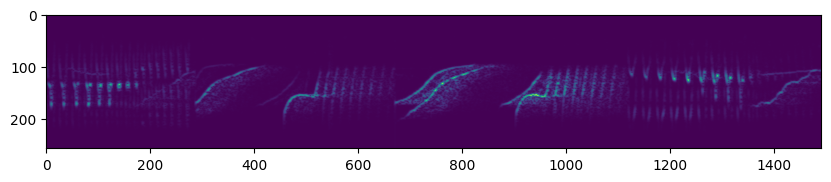

In [55]:
filepath, label = ds.shuffle(1000).as_numpy_iterator().next()
spectrogram, label = process_audio(filepath, label)

plt.figure(figsize=(10, 6))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

#### Build data pipeline and split into train/test subsets

In [70]:
# Process and batch dataset
ds = ds.map(process_audio)
ds = ds.cache()
ds = ds.shuffle(buffer_size=10000)
ds = ds.batch(32)
ds = ds.prefetch(tf.data.AUTOTUNE)

In [71]:
# Split dataset
SPLIT = 0.7

train_split = int(len(ds) * SPLIT)
train_ds = ds.take(train_split)
test_ds = ds.skip(train_split)

### Create and train CNN model

In [72]:
unique_class_count = len(labels_dict)

model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(1491, 257, 1)),
  
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.2),
  
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(3,3)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  
  tf.keras.layers.Dense(units=unique_class_count, activation='softmax')
  ])

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 744, 127, 16)     0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 744, 127, 16)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 247, 41, 16)      0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 247, 41, 16)      

In [ ]:
EPOCHS = 30
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

#### Plotting model accuracy and loss

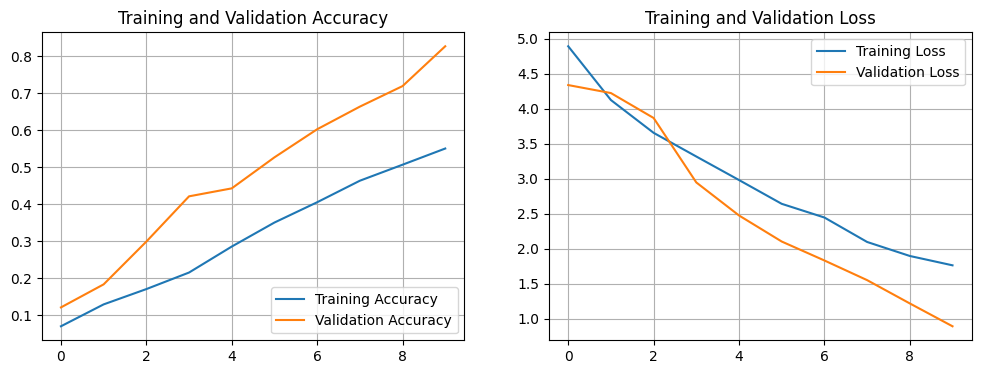

In [148]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.grid()
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.grid()
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

figure = plt.gcf()
plt.show()

#### Save and load Keras models

##### Save model

In [149]:
model_name = str(input('Enter a title for the saved model...'))
model_path = f'../models/{model_name}/'

if model_name:
  try:
    os.mkdir(model_path)
    model.save(model_path + f'{model_name}.keras')
    print(f'Model successfully saved to {model_path}{model_name}.')
    
    # Remember to execute plotting cell first
    figure.savefig(model_path + f'{model_name}.png') 
  except:
    raise('ERROR: Model name is already in use. Pick another name and try again.')

Model successfully saved to ../models/01-cnn_xeno_canto_arg-10ep-3s_audio/01-cnn_xeno_canto_arg-10ep-3s_audio.


##### Load model

In [ ]:
model_name = str(input('Type model name...'))

if model_name:
  model_path = f'../models/{model_name}/'

# model = tf.keras.models.load_model(model_path + f'{model_name}.keras')

### Testing

Label histogram of audio files.

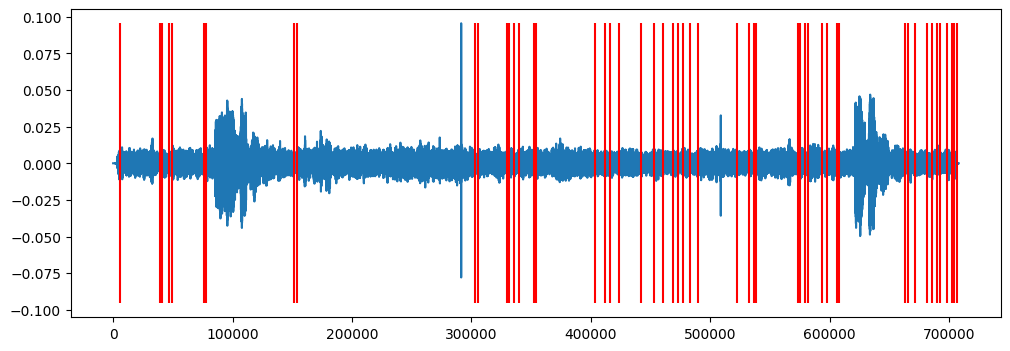

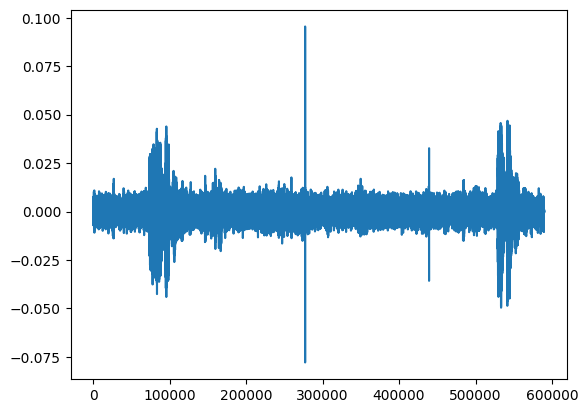

In [38]:
path = r'C:\Users\matia\Desktop\ornithologist\datasets\xeno-canto_argentina\unprocessed_audio_files\Common Potoo\Common Potoo_483746.mp3'
y, sr = li.load(path, sr=16000, mono=True)

splitted = remove_silence(y, thresh=18, hop=2048, plot=True)

plt.figure()
plt.plot(splitted)
plt.show()